In [1]:
%matplotlib notebook
#!pip install ipympl
#%matplotlib widget
#%matplotlib inline
#%matplotlib tk
#%matplotlib qt

In [2]:
import qcodes as qc
## Multidimensional scanning module
from qcodes.dataset import (
    LinSweep,
    Measurement,
    dond,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
## Using interactive widget
from qcodes.interactive_widget import experiments_widget
from qcodes.parameters import ScaledParameter, Parameter

from FridgeStation import Fridge, module_and_phase, goToVoltage, goToGround, mfli_module, mfli_phase, my_str
from DriverStahl import Stahl, StahlChannel
from DriverKeithley2110 import Keithley2110
from IPS120 import OxfordInstruments_IPS120

from zhinst.toolkit import Session

import numpy as np
import seaborn as sns
from math import ceil
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Button, CheckButtons
from tqdm import tqdm # Used for displaying a progress bar
from datetime import datetime #datetime class from datetime package
plt.rcParams.update({'font.size': 15})
import pyqtgraph as pg
from PyQt5.QtWidgets import QApplication
from PyQt5.QtCore import QTimer
import numpy as np
import threading
import time
from matplotlib.widgets import Button


# Calibration curve of the $RuO_2$ thermometer

In [3]:
def calibration(R):
#     if R > 2446.94: # 0.05 to 0.95 K
#         Z1 = np.log10(R)
#         ZL1 = 3.35453159798 ; ZU1 = 5.00000000000
#         k1 = ((Z1-ZL1) - (ZU1-Z1)) / (ZU1-ZL1)
#         A1 = np.array([0.300923,-0.401714, 0.220055,-0.098891, 0.046804,-0.017379, 0.009090,-0.002703, 0.002170])
#         T = np.polynomial.chebyshev.chebval(k1, A1)
#     elif R > 1247.71: # 0.95 to 6.5 K
#         Z2 = np.log10(R)
#         ZL2 = 3.08086045368 ; ZU2 = 3.44910010859
#         k2 = ((Z2-ZL2) - (ZU2-Z2)) / (ZU2-ZL2)
#         A2 = np.array([2.813252,-2.976371, 1.299095,-0.538334, 0.220456,-0.090969, 0.037095,-0.015446, 0.005104,-0.004254])
#         T = np.polynomial.chebyshev.chebval(k2, A2)
#     else: # 6.5 to 40 K
#         Z3 = np.log10(R)
#         ZL3 = 2.95500000000 ; ZU3 = 3.10855552727
#         k3 = ((Z3-ZL3) - (ZU3-Z3)) / (ZU3-ZL3)
#         A3 = np.array([3074.395992,-5680.735415, 4510.873058,-3070.206226, 1775.293345, -857.606658, 336.220971, -101.617491, 21.390256, -2.407847])
#         T = np.polynomial.chebyshev.chebval(k3, A3)
#     return T
    ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))
    T = np.exp(ln_T)
    return T

In [4]:
# N = 1000
# R = np.linspace(7000, 65000, N) ; T = np.zeros(N)
# #R1 = np.linspace(63765.1, 2446.94, N) ; T1 = np.zeros(N)
# #R2 = np.linspace(2446.94, 1247.71, N) ; T2 = np.zeros(N)
# #R3 = np.linspace(1247.71, 1049.08, N) ; T3 = np.zeros(N)
# for i in range(N):
#     T[i] = calibration(R[i])
#     #T1[i] = calibration(R1[i])
#     #T2[i] = calibration(R2[i])
#     #T3[i] = calibration(R3[i])

# fig, ax = plt.subplots(figsize = (10, 6.18))

# ax.plot(T,R)
# #ax.plot(T1, R1)
# #ax.plot(T2, R2)
# #ax.plot(T3, R3)

# ax.set_ylabel("Resistance ($\Omega$)")
# ax.set_xlabel("Temperature (K)")
# #ax.set_xscale("log")
# ax.set_yscale("log")

# ax.grid(alpha = 0.3, ls = "--")

# plt.show()

# Preparing the experiment

## Creation of the *station*

A station is a collection of all the instruments and devices present in your experiment

In [5]:
station = Fridge() # Creates an instantiation from the "Fridge" class

dmm_dict    = {"name":"Keithley_leakage", "address":"GPIB0::16::INSTR"}
mfli_dict   = {"serial":["dev4451","dev3213","dev7605"], "dataserver":"localhost"}
HV_dict     = {"name":"HV062",            "address":"COM14"           }
LV_dict     = {"name":"HV090",            "address":"COM2"            }
magnet_dict = {"name":"IPS120",           "address":"GPIB2::30::INSTR"}

dmm, mflis, daq_mfli, HV, LV, magnet = station.default_initialisation(dmm_dict = dmm_dict, mfli_dict = mfli_dict, HV_dict = HV_dict, LV_dict = LV_dict, magnet_dict = magnet_dict)

mfli4451 = mflis[0]
mfli3213 = mflis[1]
mfli7605 = mflis[2]

Connected to: KEITHLEY INSTRUMENTS INC. 2700 (serial:0755493, A01  /A02) in 0.39 s
Connected to: Zurich Instruments MFLI (serial:dev4451, firmware:68953) in 0.25s
Connected to: Zurich Instruments MFLI (serial:dev3213, firmware:68953) in 0.22s
Connected to: Zurich Instruments MFLI (serial:dev7605, firmware:69426) in 0.18s
Connected to: HV062 with 2 channels and reaching 200V in 0.07 s
Connected to: HV090 with 4 channels and reaching 14V in 0.03 s
Connected to: Oxford Instruments IPS120 (serial:None, firmware:None) in 0.16s


In [6]:
# # Creates a station without a magnet

# station = Fridge() # Creates an instantiation from the "Fridge" class

# dmm_dict = {"name":"Keithley_leakage", "address":"GPIB0::16::INSTR"}
# mfli_dict = {"serial":["dev4451","dev3213","dev7605"], "dataserver":"localhost"}
# HV_dict = {"name":"HV062", "address":"COM14"}
# LV_dict = {"name":"HV090", "address":"COM2"}

# dmm, mflis, daq_mfli, HV, LV = station.default_initialisation(dmm_dict = dmm_dict, mfli_dict = mfli_dict, HV_dict = HV_dict, LV_dict = LV_dict)

# mfli4451 = mflis[0]
# mfli3213 = mflis[1]
# mfli7605 = mflis[2]

### Multimeter

In [6]:
dmm.DCvoltage() # Digital multimeter used for measuring leakage current
Vleak = dmm.amplitude
Rleak = 1e9 # 1Gohms resistance put in series with the gate
conversion = 1/Rleak
Ileak = ScaledParameter(Vleak, gain=conversion, name = "Ileak", unit = "A") # R = V/Ithermometer in kOhms

In [7]:
dmm.amplitude()

-0.0365206525

### HV & LV DC sources

In [8]:
HVch = HV.channels[0]
print("High voltage = " + str(HVch.voltage()) + "V")
LVch = LV.channels[1]
print("Low voltage = " + str(LVch.voltage()) + "V")

High voltage = 0.1V
Low voltage = -0.002V


### MFLI

In [9]:
Isample = 10e-9 # Current we want to pass in the sample
Rseries = 10e6 # Resistance in series with the sample
Vout = Rseries*Isample
print(Vout)

Ithermometer = 1e-9
RseriesThermometer = 100e6
Vthermometer = RseriesThermometer * Ithermometer
print(Vthermometer)

0.1
0.1


#### $V_{xx}$ & $I_{xx}$

In [10]:
mfli4451.oscs.freq(17) # Sets the frequency of the 4 oscillators

mfli4451.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli4451.demods.timeconstant(1) # Changes tc for all oscillators
mfli4451.demods[0,1].enable(1) # Turns on demodulators
mfli4451.demods[2,3].enable(0) # Turns off demodulators
mfli4451.demods[0].adcselect(0) # First demodulator is signal in
mfli4451.demods[1].adcselect(1) # Second demodulator is current in

# We only have 1 voltage input, but still we precise sigins[0]
mfli4451.sigins[0].autorange(1) # Autorange for signal in
mfli4451.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 current input, but still we precise currins[0]
mfli4451.currins[0].autorange(1) # Autorange for current in

# We only have 1 voltage output, but still we precise sigouts[0]
mfli4451.sigouts[0].range(Vout*10)
mfli4451.sigouts[0].amplitudes[0].value(Vout*np.sqrt(2)) # Sets the peak to peak amplitude
mfli4451.sigouts[0].amplitudes[1,2,3].value(0)
mfli4451.sigouts[0].enables[0].value(1) # Activates the first output
mfli4451.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli4451.sigouts[0].autorange(1)
mfli4451.sigouts[0].on(1)

#### $V_{xy}$

In [11]:
mfli7605.oscs.freq(17)

mfli7605.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli7605.demods.timeconstant(1) # Changes tc for all oscillators
mfli7605.demods[0].enable(1) # Turns on demodulators
mfli7605.demods[0].adcselect(0) # First demodulator is signal in

mfli7605.sigins[0].autorange(1) # Autorange for signal in
mfli7605.sigins[0].diff(1)      # Activates differential voltage

# We only have 1 voltage output, but still we precise sigouts[0]
mfli7605.sigouts[0].amplitudes[1].value(0) # Sets the peak to peak amplitude
mfli7605.sigouts[0].enables[1].value(0) # Deactivates the output
mfli7605.sigouts[0].autorange(1)
mfli7605.sigouts[0].on(1)

#### $RuO_2$ resistance

In [12]:
mfli3213.oscs.freq(7)

mfli3213.demods.oscselect(0) # The 4 demodulators are demodulated with the first oscillator frequency
mfli3213.demods.timeconstant(3) # Changes tc for all oscillators
mfli3213.demods[0].enable(1) # Turns on demodulators
mfli3213.demods[0].adcselect(0) # First demodulator is signal in

mfli3213.sigins[0].autorange(1) # Autorange for signal in
mfli3213.sigins[0].diff(1)      # Activates differential voltage

mfli3213.sigouts[0].range(Vthermometer*10)
mfli3213.sigouts[0].amplitudes[0].value(Vthermometer*np.sqrt(2)) # Sets the peak to peak amplitude
mfli3213.sigouts[0].amplitudes[1,2,3].value(0)
mfli3213.sigouts[0].enables[0].value(1) # Activates the first output
mfli3213.sigouts[0].enables[1,2,3].value(0) # Deactivates all other outputs
mfli3213.sigouts[0].on(1)

#### Define parameters for the MFLI

In [13]:
# Longitudinal voltage drop in the sample
Vxx        = mfli_module(mfli = mfli4451, demodulator = 0, name = "Vxx") # Parameter giving Vxx
Vxx_phase  = mfli_phase (mfli = mfli4451, demodulator = 0, name = "Vxx_phase")
conversion = 1/Isample # Converts the measured voltage into the sample resistance (Ohm)
Rxx        = ScaledParameter(Vxx, gain=conversion, name = "Rxx", unit = "Ohm") # Rxx = Vxx/Isample in kOhms

# Longitudinal current in the sample 
Ixx        = mfli_module(mfli = mfli4451, demodulator = 1, name = "Ixx") # Parameter giving Ixx
Ixx_phase  = mfli_phase (mfli = mfli4451, demodulator = 1, name = "Ixx_phase")

# Transversal voltage drop in the sample
Vxy        = mfli_module(mfli = mfli7605, demodulator = 0, name = "Vxy") # Parameter giving Isample
Vxy_phase  = mfli_phase (mfli = mfli7605, demodulator = 0, name = "Vxy_phase")
Rxy        = ScaledParameter(Vxy, gain=conversion, name = "Rxy", unit = "Ohm") # Rxx = Vxx/Isample in kOhms

# Voltage drop in the thermometer 
Vtherm        = mfli_module(mfli = mfli3213, demodulator = 0, name = "V_thermometer") # Parameter giving Vxx
Vtherm_phase  = mfli_phase (mfli = mfli3213, demodulator = 0, name = "V_thermometer_phase")
conversion    = 1/Ithermometer # Converts the measured voltage into the thermometer resistance (Ohm)
Rtherm        = ScaledParameter(Vtherm, gain=conversion, name = "R_thermometer", unit = "Ohm") # R = V/Ithermometer in kOhms
T             = Parameter(name = "Temperature", label = "Temperature", unit = "K", get_cmd = lambda:calibration(Rtherm()))

### IPS

Sweep rate field must be below:

0.4 T/min if B < 10 T

0.2 T/min if 10 T < B < 12 T

0.1 T/min if B > 12 T

In [14]:
set_ratefield = 0.1

if set_ratefield < 0.4:
    magnet.sweeprate_field(set_ratefield)
    
magnet.sweeprate_field()

0.1

## Creation of the *database* containing the data

We set up a database in order to save our data to. QCoDeS implement a SQLite3 database for this purpose.

In [16]:
initialise_or_create_database_at("Database/Sofiane_Michael_TBG02.db")

In [17]:
qc.config.core.db_location

'Database/Sofiane_Michael_TBG02.db'

# Low voltage sweep

## Creation of the *experiment*

After initializing the database we create an Experiment object. This object contains the names of the experiment and sample, and acts as a manager for data acquired during measurement.

In [20]:
TBG02_exp = load_or_create_experiment(
    experiment_name="LVsweeps",
    sample_name="TBG02"
)

In [21]:
experiments()

[DCsweeps#TBG02#1@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 ------------------------------------------------------------------------------------------------------------------
 1-DCsweep_24-21_init-1-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 2-DCsweep_24-21_sweep-2-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 3-DCsweep_24-21_end-3-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 4-DCsweep_24-11_init-4-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 5-DCsweep_24-11_sweep-5-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 6-DCsweep_24-11_end-6-HV090_CH02_voltage,resistance,zi_baseinstrument_dev4451_phase-160
 13-DCsweep_24-11_0_-2-7-HV090_CH02_voltage,Rxx,zi_baseinstrument_dev4451_Vxx_phase-80
 14-DCsweep_24-11_-2_2-8-HV090_CH02_voltage,Rxx,zi_baseinstrument_dev4451_Vxx_phase-160
 15-DCsweep_24-11_2_0-9-HV090_CH02_voltage,Rxx,zi_bas

## Creation of the *measurement*

The Measurement object is used to obtain data from instruments in QCoDeS, as such it is instantiated with both an experiment (to handle data) and station to control the instruments.

In [20]:
#meas = Measurement(exp=TBG02_exp, station=station, name='DCsweep_24-21')

In [59]:
contact1 = 24
contact2 = 21

In [60]:
stopHV  = 30 #V
dVHV    = 0.5 #V
NHV     = int(stopHV//dVHV + 1)
dtHV    = 1

start = -3
stop  = 3
dV    = 0.05
N     = int(abs(stop-start)//dV + 1) #number of points in the full sweep
dt    = 3 #s
tc    = 1 #demodulator time constant, s
speed_up = 2 #factor by which to speed up the init and end steps

print("Sweep will take : " + str(int((1+1/speed_up)*N*dt//60)) + " min " + str(int((1+1/speed_up)*N*dt%60)) + " s with speed up" )

Sweep will take : 9 min 0 s with speed up


In [61]:
# Setting up a doNd measurement
HVsweep1 = LinSweep(HVch.voltage, 0, stopHV, NHV, dtHV)

LVsweep1 = LinSweep(LVch.voltage, 0,     start, N//2, dt/speed_up)
LVsweep2 = LinSweep(LVch.voltage, start, stop,  N, dt)
LVsweep3 = LinSweep(LVch.voltage, stop,  0,     N//2, dt/speed_up)

HVsweep2 = LinSweep(HVch.voltage, stopHV, 0, NHV, dtHV)

mfli4451.demods.timeconstant(tc)

In [62]:
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Contact doping
dond(
    HVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + f"_{contact1}-{contact2}_0V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Go to the start point from 0
dond(
    LVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_0V_{my_str(start)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

#Sweeps
dond(
    LVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(start)}V_{my_str(stop)}V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Go back to 0 from stop
dond(
    LVsweep3,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + f"_{contact1}-{contact2}_{my_str(stop)}V_0V_dV{my_str(dV)}V_dt{my_str(dt)}s_tc{my_str(tc)}s",   # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

# Contact doping
dond(
    HVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="HVsweep" + f"_{contact1}-{contact2}_{my_str(stopHV)}V_0V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 74. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experimental run with id: 75. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 76. Using 'qcodes.dataset.dond'


  0%|          | 0/120 [00:00<?, ?it/s]

Starting experimental run with id: 77. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

Starting experimental run with id: 78. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

(HVsweep_24-21_30V_0V_dV0,5V_dt1s_tc1s #78@C:\Users\labo-admin\experiments.db
 ----------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 I_leak - numeric
 Temperature - numeric,
 (None,),
 (None,))

# HV Sweep

## Creation of the experiment

In [109]:
contactI1  = 24
contactI2  = 18
contactV1  = 21
contactV2  = 11
contactVxy = 16

startHV = 30
stopHV  = 0
dVHV = 0.5
dtHV = 1
NHV = ceil(abs((stopHV-startHV))/dVHV + 1)

tc = 1

In [104]:
TBG02_exp_HV = load_or_create_experiment(
    experiment_name="HVsweeps",
    sample_name="TBG02"
)

## Creation of the measurement 

In [111]:
#prepare the system for mapping

HV_sweep_init = LinSweep(HVch.voltage, startHV, stopHV, NHV, dtHV) # Contact doping
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

dond(
    HV_sweep_init,                          # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Rxy,                                    # 3rd dependent parameter
    Vxy_phase,                              # 4th dependent parameter
    Ileak,                                  # 5th dependent parameter
    T,                                      # 6th dependent parameter
    measurement_name= "HVsweep" + f"_{contactI1}-{contactI2}_{contactV1}-{contactV2}_{contactVxy}_{my_str(startHV)}V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp_HV,         # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

Starting experimental run with id: 57. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

In [22]:
# Setting up a doNd measurement
start = -30 ; stop = 30 ; dV = 0.5 ; N = int(abs(stop-start)//dV + 1) ; dt = 3
HVsweep1 = LinSweep(HVch.voltage, 0,     start, N//2, dt)
HVsweep2 = LinSweep(HVch.voltage, start, stop,  N, dt)
HVsweep3 = LinSweep(HVch.voltage, stop,  0,     N//2, dt)

print("Sweep will take : " + str(int(2*N*dt//60)) + " min " + str(int(2*N*dt%60)) + " s")

mfli4451.demods.timeconstant(dt)

Sweep will take : 12 min 6 s


Starting experimental run with id: 22. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


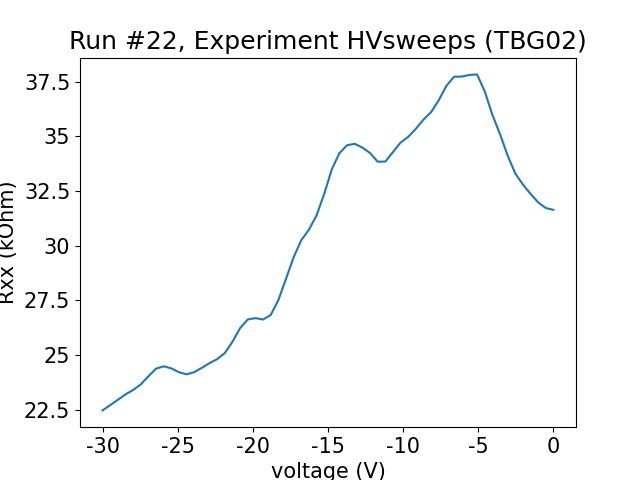

<IPython.core.display.Javascript object>


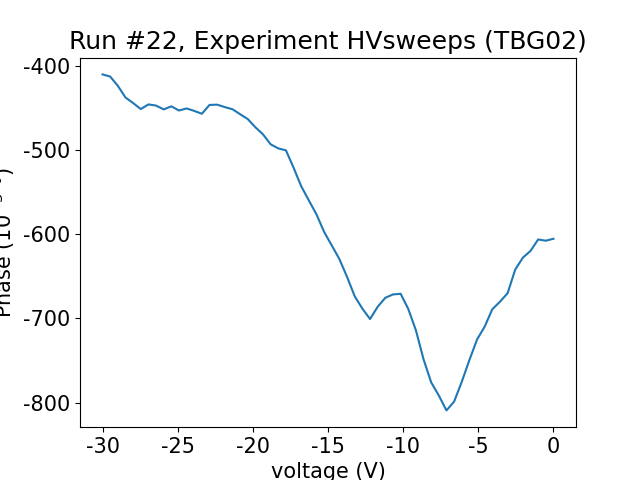

Starting experimental run with id: 23. Using 'qcodes.dataset.dond'


  0%|          | 0/121 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


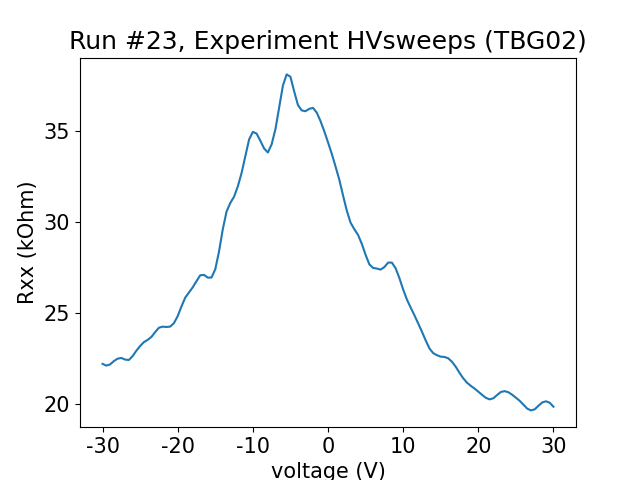

<IPython.core.display.Javascript object>


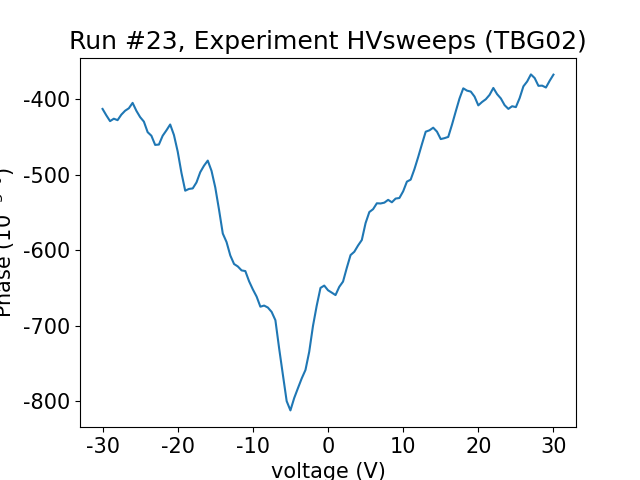

Starting experimental run with id: 24. Using 'qcodes.dataset.dond'


  0%|          | 0/60 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


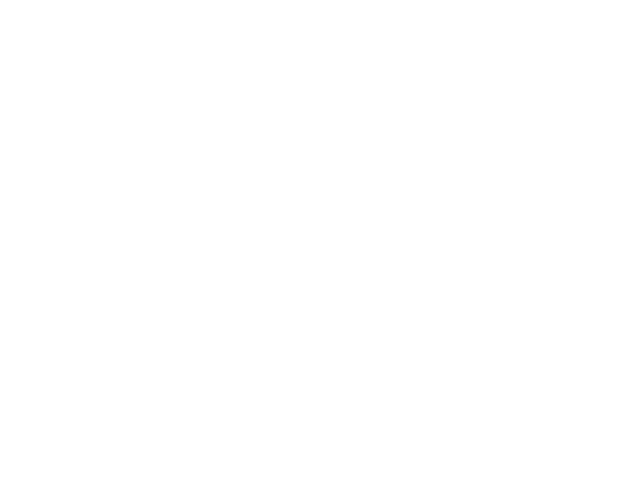

<IPython.core.display.Javascript object>


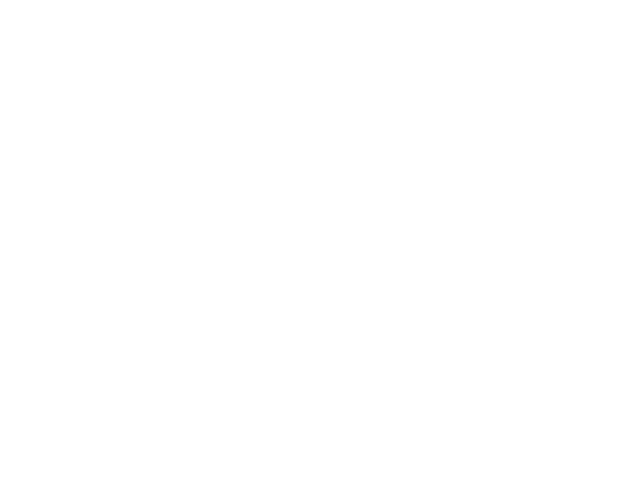

(HVsweep_24-11_30_0_3 #24@C:\Users\labo-admin\experiments.db
 -----------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric,
 (<Axes: title={'center': 'Run #24, Experiment HVsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='Rxx (kOhm)'>,
  <Axes: title={'center': 'Run #24, Experiment HVsweeps (TBG02)'}, xlabel='voltage (V)', ylabel='Phase ($10^{-3}$ $\\degree$)'>),
 (None, None))

In [23]:
# Go to the start point from 0
dond(
    HVsweep1,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_0_-30_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=False
)

#Sweeps
dond(
    HVsweep2,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_-30_30_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=False
)

# Go back to 0 from stop
dond(
    HVsweep3,                             # 1st independent parameter
    Rxx,                           # 1st dependent parameter
    Vxx_phase,                         # 2nd dependent parameter
    measurement_name="HVsweep_24-11_30_0_3",     # Set the measurement name
    exp=TBG02_exp_HV,                        # Set the experiment to save data to.
    show_progress=True,                   # Optional progress bar
    do_plot=False
)

# Magnetotransport measurement

## Creation of the experiment

In [18]:
TBG02_exp_magnetotransport = load_or_create_experiment(
    experiment_name="Magnetotransport_trial",
    sample_name="TBG02"
)

## Creation of the measurement

In [19]:
contact1 = 24
contact2 = 21

In [20]:
stopHV  = 30 #V
dVHV    = 0.5 #V
NHV     = int(stopHV//dVHV + 1)
dtHV    = 1

start = 0
stop  = 0.1
dB    = 0.01
N     = int(abs(stop-start)//dB + 1) #number of points in the full sweep
tc    = 1 #demodulator time constant, s
dt    = 4*tc #s

print("Sweep will take : " + str(int(N*dt//60)) + " min " + str(int(N*dt%60)) + " s with speed up" )

Sweep will take : 0 min 44 s with speed up


In [32]:
# Setting up a doNd measurement
HVsweep1 = LinSweep(HVch.voltage, 0, stopHV, NHV, dtHV)

Bsweep = LinSweep(magnet.B, start, stop, N, dt)

HVsweep2 = LinSweep(HVch.voltage, stopHV, 0, NHV, dtHV)

mfli4451.demods.timeconstant(tc)

In [40]:
mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

# Contact doping
dond(
    HVsweep1,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + f"_{contact1}-{contact2}_0V_{my_str(stopHV)}V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

mfli4451.sigins[0].autorange(1) # Autorange for signal in
time.sleep(10)

#Sweeps
dond(
    Bsweep,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="Bsweep" + f"_{contact1}-{contact2}_{my_str(start)}T_{my_str(stop)}T_dB{my_str(dB)}T_dt{my_str(dt)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

magnet.leave_persistent_mode()
magnet.run_to_field_wait(0)
magnet.heater_off()

# Contact doping
dond(
    HVsweep2,                               # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="HVsweep" + f"_{contact1}-{contact2}_{my_str(stopHV)}V_0V_dV{my_str(dVHV)}V_dt{my_str(dtHV)}s_tc{my_str(tc)}s",  # Set the measurement name
    exp=TBG02_exp,                          # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 42. Using 'qcodes.dataset.dond'


  0%|          | 0/61 [00:00<?, ?it/s]

Starting experimental run with id: 43. Using 'qcodes.dataset.dond'


  0%|          | 0/11 [00:00<?, ?it/s]

Heater is off, field is zero. Turning on switch heater.
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Heater is off, field is zero. Turning on switch heater.
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become superconducting
Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)
Waiting for the switch heater to become supercon

  0%|          | 0/61 [00:00<?, ?it/s]

(HVsweep_24-21_30V_0V_dV0,5V_dt1s_tc1s #44@C:\Users\labo-admin\Desktop\Mesures TBG\C2N_September24_stack02\Database\Sofiane_Michael_TBG02.db
 -------------------------------------------------------------------------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 I_leak - numeric
 Temperature - numeric,
 (None,),
 (None,))

# 2D voltage map

In [105]:
TBG02_exp_magnetotransport = load_or_create_experiment(
    experiment_name="Misc",
    sample_name="TBG02"
)

In [106]:
contactI1  = 24
contactI2  = 18
contactV1  = 21
contactV2  = 11
contactVxy = 16

In [107]:
tc      = 1 #demodulator time constant, s

startHV = 0
stopHV  = 1.5 #V
dVHV    = 0.5 #V
NHV     = int(stopHV//dVHV + 1)
dtHV    = 1

startLV = 0
stopLV  = 0.1
dVLV    = 0.05
NLV     = ceil(abs(stopLV-startLV)/dVLV + 1) #number of points in the full sweep
dtLV    = 4*tc #s


In [108]:
contacts_name = f"_{contactI1}-{contactI2}_{contactV1}-{contactV2}_{contactVxy}"
HV_name       = f"_{my_str(startHV)}T_{my_str(stopHV)}T_dB{my_str(dVHV)}T"
LV_name       = f"_{my_str(startLV)}V_{my_str(stopLV)}V_dV{my_str(dVLV)}"
time_name     = f"_dt{my_str(dtLV)}_tc{my_str(tc)}"
name = contacts_name + HV_name + LV_name + time_name

map_measurement = Measurement(exp=TBG02_exp_magnetotransport,
                              station=station,
                              name="V2D" + name)

In [109]:
dependent_parameters = [Rxx, Vxx_phase, Rxy, Vxy_phase, Ileak, T]

In [110]:
# Register the independent parameters...
map_measurement.register_parameter(HVch.voltage)
map_measurement.register_parameter(LVch.voltage)

# ...then register the dependent parameters
for parameter in dependent_parameters :
    map_measurement.register_parameter(parameter, setpoints=(HVch.voltage, LVch.voltage))

#Set shape for acquired data
map_measurement.set_shapes({str(parameter) : (NHV,NLV) for parameter in dependent_parameters}) 

In [111]:
map_measurement.parameters

{'Rxx': ParamSpecBase('Rxx', 'numeric', 'Rxx', 'Ohm'),
 'HV062_CH01_voltage': ParamSpecBase('HV062_CH01_voltage', 'numeric', 'voltage', 'V'),
 'HV090_CH02_voltage': ParamSpecBase('HV090_CH02_voltage', 'numeric', 'voltage', 'V'),
 'zi_baseinstrument_dev4451_Vxx_phase': ParamSpecBase('zi_baseinstrument_dev4451_Vxx_phase', 'numeric', 'Phase', '$\degree$'),
 'Rxy': ParamSpecBase('Rxy', 'numeric', 'Rxy', 'Ohm'),
 'zi_baseinstrument_dev7605_Vxy_phase': ParamSpecBase('zi_baseinstrument_dev7605_Vxy_phase', 'numeric', 'Phase', '$\degree$'),
 'Ileak': ParamSpecBase('Ileak', 'numeric', 'Ileak', 'A'),
 'Temperature': ParamSpecBase('Temperature', 'numeric', 'Temperature', 'K')}

In [112]:
# #prepare the system for mapping

# LV_sweep_init = LinSweep(LVch.voltage, 0, startLV, NLV//2, dtLV) # Go to the LV start point from 0

# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

# dond(
#     LV_sweep_init,                          # 1st independent parameter
#     Rxx,                                    # 1st dependent parameter
#     Vxx_phase,                              # 2nd dependent parameter
#     Ileak,                                  # 3rd dependent parameter
#     T,                                      # 4th dependent parameter
#     measurement_name="LVsweep" + name,      # Set the measurement name
#     exp=TBG02_exp_magnetotransport,         # Set the experiment to save data to.
#     show_progress=True,                     # Optional progress bar
#     do_plot=False
# )

# mfli4451.sigins[0].autorange(1) # Autorange for signal in
# time.sleep(10)

In [115]:
print((HVch.voltage, set_HV),     # 1st independent parameter
     (LVch.voltage, set_V),         # 2nd independent parameter
     (Rxx, Rxx()),              # 1st dependent parameter
     (Vxx_phase, Vxx_phase()),  # 2nd dependent parameter
     (Rxy, Rxy()),              # 3nd dependent parameter
     (Vxy_phase, Vxy_phase()),  # 4th dependent parameter
     (Ileak, Ileak()),          # 5th dependent parameter
     (T, T()))   

(<qcodes.parameters.parameter.Parameter: voltage at 2681917743120>, 1.5) (<qcodes.parameters.parameter.Parameter: voltage at 2681917607888>, 0.0) (<qcodes.parameters.scaled_paramter.ScaledParameter: Rxx at 2681716682768>, 0.4380159749153339) (<FridgeStation.mfli_phase: Vxx_phase at 2681806207376>, -99.26171535933582) (<qcodes.parameters.scaled_paramter.ScaledParameter: Rxy at 2681906035920>, 0.5071462754532429) (<FridgeStation.mfli_phase: Vxy_phase at 2681906038992>, -167.4221676865186) (<qcodes.parameters.scaled_paramter.ScaledParameter: Ileak at 2681829692816>, -7.10546076e-11) (<qcodes.parameters.parameter.Parameter: Temperature at 2681906030864>, nan)


C:\Users\labo-admin\AppData\Local\Temp\ipykernel_4896\3089662529.py:21: RuntimeWarning: invalid value encountered in log
  ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))


## Run Mapping

In [124]:
#map_measurement.write_period = 2

#sweep ranges for map
LV_forward_sweep  = np.linspace(startLV, stopLV, NLV) 
LV_backward_sweep = np.linspace(stopLV, startLV, NLV)
HV_sweep = np.linspace(0, stopHV, NHV)

with map_measurement.run(write_in_background=True) as datasaver:
    for i, set_HV in enumerate(HV_sweep): #magnetic field iteration
        
        HVch.voltage(set_HV)
        
        LVsweep = LV_forward_sweep if i%2 == 0 else LV_backward_sweep
        #LVsweep = LV_forward_sweep
        #print(LVsweep)
        
        time.sleep(dtHV)
        
        HVch_sweep       = []
        LVch_sweep       = []
        Rxx_sweep        = []
        Vxx_phase_sweep  = []
        Rxy_sweep        = []
        Vxy_phase_sweep  = []
        Ileak_sweep      = []
        T_sweep          = []
        
        for set_LV in LVsweep : #back gate voltage iteration
            
            LVch.voltage(set_LV)
            time.sleep(dtLV)
            
            HVch_sweep.append(set_HV)
            LVch_sweep.append(set_LV)
            Rxx_sweep.append(Rxx())
            Vxx_phase_sweep.append(Vxx_phase())
            Rxy_sweep.append(Rxy())
            Vxy_phase_sweep.append(Vxy_phase())
            Ileak_sweep.append(Ileak())
            T_sweep.append(T())
            

        if i%2 == 0:
            print(LVch_sweep)
            datasaver.add_result((HVch.voltage, HVch_sweep),     # 1st independent parameter
                                 (LVch.voltage, LVch_sweep),     # 2nd independent parameter
                                 (Rxx, Rxx_sweep),              # 1st dependent parameter
                                 (Vxx_phase, Vxx_phase_sweep),  # 2nd dependent parameter
                                 (Rxy, Rxy_sweep),              # 3nd dependent parameter
                                 (Vxy_phase, Vxy_phase_sweep),  # 4th dependent parameter
                                 (Ileak, Ileak_sweep),          # 5th dependent parameter
                                 (T, T_sweep))                  # 6th dependent parameter
        else:
            print(LVch_sweep[::-1])
            datasaver.add_result((HVch.voltage, HVch_sweep[::-1]),     # 1st independent parameter
                     (LVch.voltage, LVch_sweep[::-1]),     # 2nd independent parameter
                     (Rxx, Rxx_sweep[::-1]),              # 1st dependent parameter
                     (Vxx_phase, Vxx_phase_sweep[::-1]),  # 2nd dependent parameter
                     (Rxy, Rxy_sweep[::-1]),              # 3nd dependent parameter
                     (Vxy_phase, Vxy_phase_sweep[::-1]),  # 4th dependent parameter
                     (Ileak, Ileak_sweep[::-1]),          # 5th dependent parameter
                     (T, T_sweep[::-1]))                  # 6th dependent parameter

    # Convenient to have for plotting and data access
    dataset = datasaver.dataset

Starting experimental run with id: 33. 
[0.0]


C:\Users\labo-admin\AppData\Local\Temp\ipykernel_4896\3089662529.py:21: RuntimeWarning: invalid value encountered in log
  ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))



[0.0, 0.0]

[0.0, 0.0, 0.0]

[0.0, 0.05, 0.1]
[0.5]

[0.5, 0.5]

[0.5, 0.5, 0.5]

[0.0, 0.05, 0.1]
[1.0]

[1.0, 1.0]

[1.0, 1.0, 1.0]

[0.0, 0.05, 0.1]
[1.5]

[1.5, 1.5]

[1.5, 1.5, 1.5]

[0.0, 0.05, 0.1]


In [104]:
datasaver.

0.0

In [125]:
datasaver.dataset.get_parameter_data()

{'Ileak': {'Ileak': array([[-7.78712332e-11, -7.79717416e-11, -7.80502111e-11],
         [-7.81055093e-11, -7.79757574e-11, -7.80278370e-11],
         [-7.80924037e-11, -7.80785605e-11, -7.79224187e-11],
         [-7.80698881e-11, -7.80651346e-11, -7.80406818e-11]]),
  'HV062_CH01_voltage': array([[0. , 0. , 0. ],
         [0.5, 0.5, 0.5],
         [1. , 1. , 1. ],
         [1.5, 1.5, 1.5]]),
  'HV090_CH02_voltage': array([[0.  , 0.05, 0.1 ],
         [0.  , 0.05, 0.1 ],
         [0.  , 0.05, 0.1 ],
         [0.  , 0.05, 0.1 ]])},
 'Rxx': {'Rxx': array([[0.17793124, 0.07639799, 0.32484076],
         [0.03454232, 0.21430247, 0.27596238],
         [0.23400585, 0.3040298 , 0.30168926],
         [0.08980743, 0.15140953, 0.41545896]]),
  'HV062_CH01_voltage': array([[0. , 0. , 0. ],
         [0.5, 0.5, 0.5],
         [1. , 1. , 1. ],
         [1.5, 1.5, 1.5]]),
  'HV090_CH02_voltage': array([[0.  , 0.05, 0.1 ],
         [0.  , 0.05, 0.1 ],
         [0.  , 0.05, 0.1 ],
         [0.  , 0.05, 

In [94]:
LV_sweep = LinSweep(LVch.voltage, startLV, stopLV, NLV, dtLV) # Go to 0 on LV
HV_sweep = LinSweep(HVch.voltage, startHV, stopHV, NHV, dtHV) # Go to 0 on LV

dataset2,axis,cbar = dond(
    HV_sweep,                               # 1st independent parameter
    LV_sweep,
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Rxy,
    Vxy_phase,
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + name,  # Set the measurement name
    exp=TBG02_exp_magnetotransport,         # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

Starting experimental run with id: 24. Using 'qcodes.dataset.dond'


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\labo-admin\AppData\Local\Temp\ipykernel_4896\3089662529.py:21: RuntimeWarning: invalid value encountered in log
  ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))


In [99]:
dataset2.get_parameter_data()["Ileak"]['HV090_CH02_voltage'] == dataset.get_parameter_data()["Ileak"]['HV090_CH02_voltage']

array([[ True,  True,  True],
       [False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

In [126]:
dataset2.get_parameter_data()["Ileak"]['HV090_CH02_voltage']

array([[0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ]])

In [127]:
dataset.get_parameter_data()["Ileak"]['HV090_CH02_voltage']

array([[0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ],
       [0.  , 0.05, 0.1 ]])

In [128]:
#Return system to ground after mapping

if NHV%2==0:
    LV_end = startLV
else:
    LV_end = stopLV 
    
LV_sweep_end = LinSweep(LVch.voltage, stopLV,    0, NLV, dtLV) # Go to 0 on LV

dond(
    LV_sweep_end,                           # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Rxy,
    Vxy_phase,
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name="LVsweep" + name,  # Set the measurement name
    exp=TBG02_exp_magnetotransport,         # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)

HV_sweep_end = LinSweep(HVch.voltage, stopHV,    0, NHV, dtHV) # Go to 0 on HV

dond(
    HV_sweep_end,                          # 1st independent parameter
    Rxx,                                    # 1st dependent parameter
    Vxx_phase,                              # 2nd dependent parameter
    Rxy,
    Vxy_phase,
    Ileak,                                  # 3rd dependent parameter
    T,                                      # 4th dependent parameter
    measurement_name= "HVsweep" + name,  # Set the measurement name
    exp=TBG02_exp_magnetotransport,         # Set the experiment to save data to.
    show_progress=True,                     # Optional progress bar
    do_plot=False
)


Starting experimental run with id: 34. Using 'qcodes.dataset.dond'


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\labo-admin\AppData\Local\Temp\ipykernel_4896\3089662529.py:21: RuntimeWarning: invalid value encountered in log
  ln_T = -2.6553952011*np.log(-8.1866484759+0.98155249557*np.log(R))


Starting experimental run with id: 35. Using 'qcodes.dataset.dond'


  0%|          | 0/4 [00:00<?, ?it/s]

(HVsweep_24-18_21-11_16_0T_1,5T_dB0,5T_0V_0,1V_dV0,05_dt4_tc1 #35@C:\Users\labo-admin\experiments.db
 ---------------------------------------------------------------------------------------------------
 HV062_CH01_voltage - numeric
 Rxx - numeric
 zi_baseinstrument_dev4451_Vxx_phase - numeric
 Rxy - numeric
 zi_baseinstrument_dev7605_Vxy_phase - numeric
 Ileak - numeric
 Temperature - numeric,
 (None,),
 (None,))

In [68]:
HVch.voltage(0)

<IPython.core.display.Javascript object>


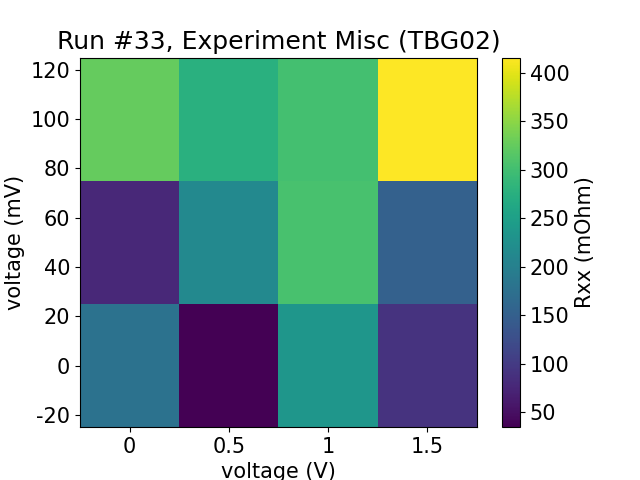

<IPython.core.display.Javascript object>


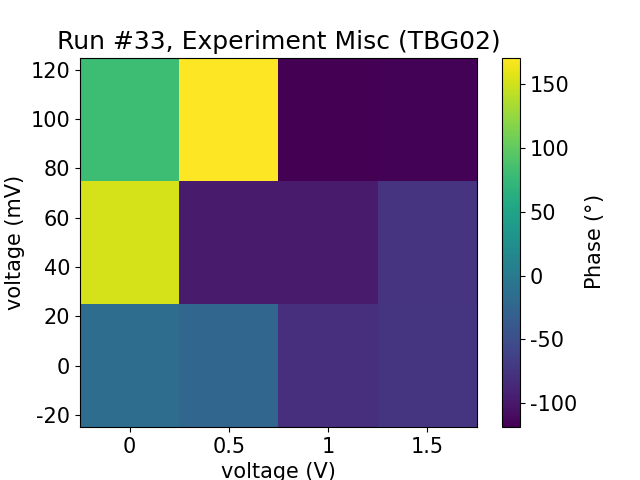

<IPython.core.display.Javascript object>


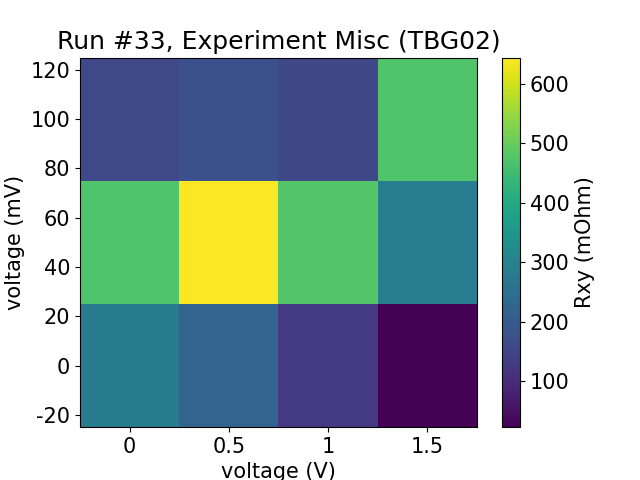

<IPython.core.display.Javascript object>


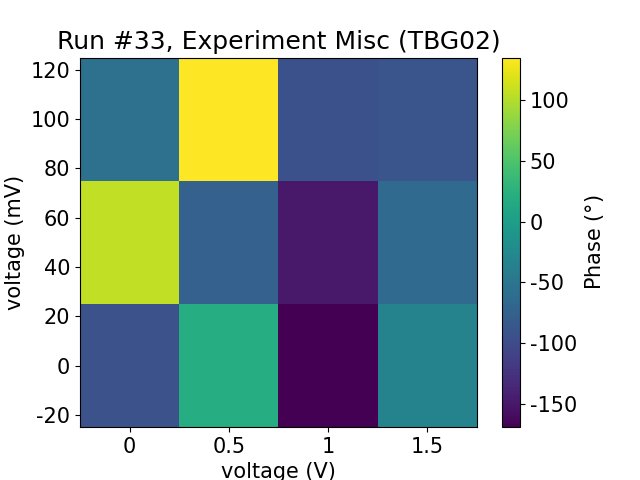

<IPython.core.display.Javascript object>


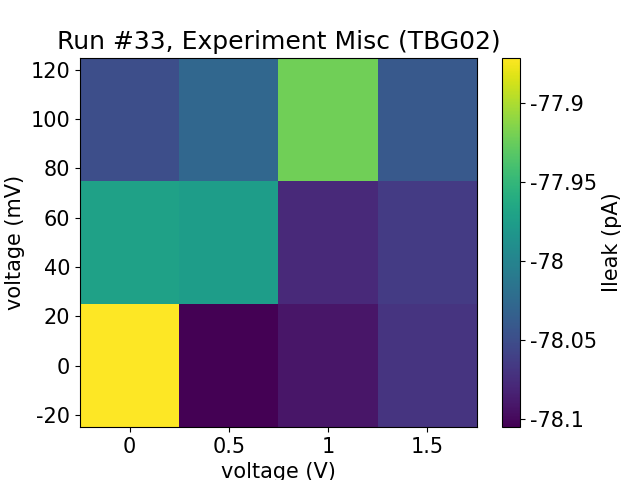

<IPython.core.display.Javascript object>


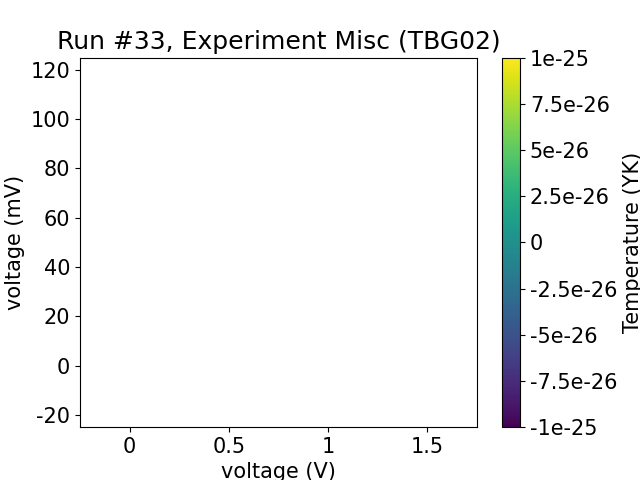

C:\Users\labo-admin\anaconda3\Lib\site-packages\qcodes\dataset\plotting.py:808: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(np.abs(data_dict["data"]))
C:\Users\labo-admin\anaconda3\Lib\site-packages\qcodes\plotting\axis_labels.py:84: RuntimeWarning: All-NaN axis encountered
  maxval = np.nanmax(np.abs(data))
C:\Users\labo-admin\anaconda3\Lib\site-packages\qcodes\plotting\axis_labels.py:92: RuntimeWarning: invalid value encountered in less
  if maxval < threshold:


([<Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>,
  <Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>,
  <Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>,
  <Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>,
  <Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>,
  <Axes: title={'center': 'Run #33, Experiment Misc (TBG02)'}, xlabel='voltage (V)', ylabel='voltage (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x27073e81d90>])

In [129]:
plot_dataset(datasaver.dataset)

In [46]:
import seaborn as sns

<IPython.core.display.Javascript object>


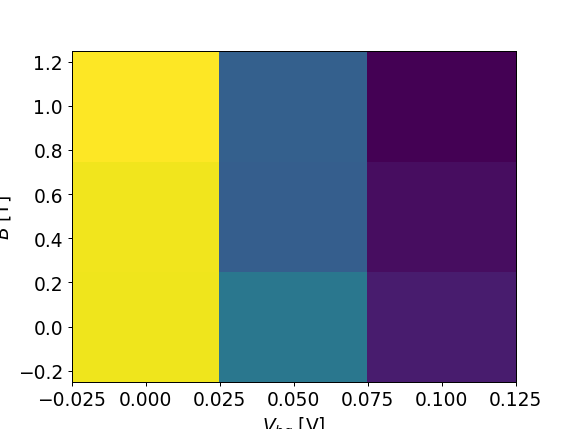

In [49]:
B_sweep = np.linspace(startHV, stopHV, NHV)
this_Rxx_data = dataset.get_parameter_data()['Rxx']
this_Rxx = this_Rxx_data['Rxx']
this_B = B_sweep
this_V = LV_forward_sweep

X, Y  = np.meshgrid(this_V, this_B)
Z = this_Rxx = this_Rxx_data['Rxx'].reshape((len(this_V), len(this_B))).T

plt.figure()
plt.ylabel('$B$ [T]')
plt.xlabel('$V_{bg}$ [V]')
plt.pcolor(X, Y, Z)
plt.show()

<IPython.core.display.Javascript object>


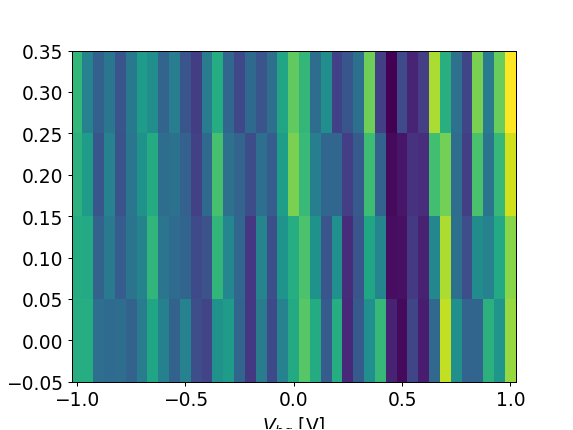

In [94]:
plt.figure()
plt.ylabel('$B$ [T]')
plt.xlabel('$V_{bg}$ [V]')
plt.pcolormesh(X, Y, Z)
plt.show()

In [44]:
magnet.B(0)

Setting switch heater... (wait 20s)
Setting switch heater... (wait 20s)


In [46]:
NB

4